# Austin Traffic Incident Report Notebook
**Description:** Using Austin Open Data Portal and the Real-Time Traffic Incident Dataset API to make a report of the last 1000 traffic accidents.\
~> [Dataset](https://data.austintexas.gov/Transportation-and-Mobility/Real-Time-Traffic-Incident-Reports/dx9v-zd7x/about_data) \
~> [API](https://data.austintexas.gov/resource/dx9v-zd7x.json)

# Traffic Reports Data Dictionary

| Column Name | Description | API Field Name | Data Type |
|-------------|------------|----------------|-----------|
| **Traffic Report ID** | Unique identifier for the traffic report | `traffic_report_id` | Text |
| **Published Date** | The date the report was published | `published_date` | Fixed Timestamp |
| **Issue Reported** | The reported issue, based on the selection by reporting agency | `issue_reported` | Text |
| **Location** | The reported incident location (point) | `location` | Point |
| **Latitude** | Latitude of the reported incident location | `latitude` | Number |
| **Longitude** | Longitude of the reported incident location | `longitude` | Number |
| **Address** | The address at which the incident was reported | `address` | Text |
| **Status** | Indicates if the reported incident is active or archived | `traffic_report_status` | Text |
| **Status Date** | The date/time at which the traffic incident was last updated | `traffic_report_status_date_time` | Fixed Timestamp |
| **Agency** | The agency reporting the incident | `agency` | Text |

**Notes:**
- Rows per page: 25
- Total records: 10

In [1]:
# Install packages
%pip install folium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
from matplotlib.dates import DateFormatter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import folium
from folium.plugins import HeatMap

In [3]:
# Replace with your actual API endpoint URL
API_URL = "https://data.austintexas.gov/resource/dx9v-zd7x.json"

def fetch_traffic_data(api_url, row_limit=1000):
    try:
        # Set up parameters to limit results
        params = {
            '$limit': min(row_limit, 1000),  # Request up to 1000 rows
            '$order': 'published_date DESC'  # Optional: get most recent first
        }
        
        # Make the API request with parameters
        response = requests.get(api_url, params=params)
        response.raise_for_status()
        
        # Parse the JSON response
        data = response.json()
        
        # Convert to DataFrame
        df = pd.json_normalize(data)
        
        # Clean up column names
        df.columns = [col.lstrip(':') for col in df.columns]
        
        # # Convert and clean data
        df = clean_traffic_data(df)
        
        # Ensure we don't exceed the row limit
        if len(df) > row_limit:
            df = df.head(row_limit)
            
        return df
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from API: {e}")
        return pd.DataFrame()

def clean_traffic_data(df):
    """Helper function to clean and transform the data"""
    # Convert timestamps
    time_cols = ['published_date', 'traffic_report_status_date_time']
    for col in time_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    
    # Convert numeric fields
    num_cols = ['latitude', 'longitude']
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

# Fetch and display the data (limited to 1000 rows)
traffic_df = fetch_traffic_data(API_URL, row_limit=1000)

if not traffic_df.empty:
    print(f"Successfully fetched {len(traffic_df)} records (limited to 1000)")
else:
    print("Failed to fetch data")

Successfully fetched 1000 records (limited to 1000)


In [4]:
traffic_df.shape

(1000, 11)

In [5]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   traffic_report_id                1000 non-null   object             
 1   published_date                   1000 non-null   datetime64[ns, UTC]
 2   issue_reported                   1000 non-null   object             
 3   latitude                         1000 non-null   float64            
 4   longitude                        1000 non-null   float64            
 5   address                          1000 non-null   object             
 6   traffic_report_status            1000 non-null   object             
 7   traffic_report_status_date_time  1000 non-null   datetime64[ns, UTC]
 8   agency                           1000 non-null   object             
 9   location.type                    994 non-null    object             
 10  l

In [6]:
traffic_df.head(3)

,traffic_report_id,published_date,issue_reported,latitude,longitude,address,traffic_report_status,traffic_report_status_date_time,agency,location.type,location.coordinates
0,74651A0D02E97130ABB18882EBB61B9FE5884603_17530...,2025-07-20 17:38:22+00:00,LOOSE LIVESTOCK,30.275117,-97.461846,Annabelle Dr / Ingrid Dr,ACTIVE,2025-07-20 17:40:14+00:00,TRAVIS COUNTY SHERIF,Point,"[-97.461846, 30.275117]"
1,73CA0CCD6FF3D0CA58884DEAAAD9E042EC048A8F_17530...,2025-07-20 16:57:53+00:00,Traffic Hazard,30.363067,-97.697058,N Lamar Blvd / W Rundberg Ln,ARCHIVED,2025-07-20 18:00:21+00:00,AUSTIN PD,Point,"[-97.697058, 30.363067]"
2,8C99E890FB1DC905B1E23FC12A520D0B6178F51A_17530...,2025-07-20 16:40:52+00:00,Crash Service,30.190959,-97.746278,5727 Palo Blanco Ln,ACTIVE,2025-07-20 16:45:18+00:00,AUSTIN PD,Point,"[-97.746278, 30.190959]"


#### Qualitative Data Options

In [7]:
print(f'traffic_report_status: {traffic_df['traffic_report_status'].unique().tolist()}')
print(f'issue_reported: {traffic_df['issue_reported'].unique().tolist()}')
print(f'agency: {traffic_df['agency'].unique().tolist()}')

traffic_report_status: ['ACTIVE', 'ARCHIVED']
issue_reported: ['LOOSE LIVESTOCK', 'Traffic Hazard', 'Crash Service', 'COLLISION', 'COLLISION/PRIVATE PROPERTY', 'Crash Urgent', 'COLLISN/ LVNG SCN', 'TRFC HAZD/ DEBRIS', 'Stalled Vehicle', 'COLLISION WITH INJURY', 'VEHICLE FIRE', 'BLOCKED DRIV/ HWY']
agency: ['TRAVIS COUNTY SHERIF', 'AUSTIN PD           ']


traffic_report_status:
- 'ACTIVE', 'ARCHIVED'
  
issue_reported:
- 'Traffic Hazard'
- 'Crash Service'
- 'COLLISION'
- 'LOOSE LIVESTOCK'
- 'COLLISION/PRIVATE PROPERTY'
- 'Crash Urgent'
- 'COLLISN/ LVNG SCN'
- 'TRFC HAZD/ DEBRIS'
- 'Stalled Vehicle'
- 'COLLISION WITH INJURY'
- 'VEHICLE FIRE'
- 'BLOCKED DRIV/ HWY'

agency: 
- 'AUSTIN PD           '
- 'TRAVIS COUNTY SHERIF'

#### Issues Reported

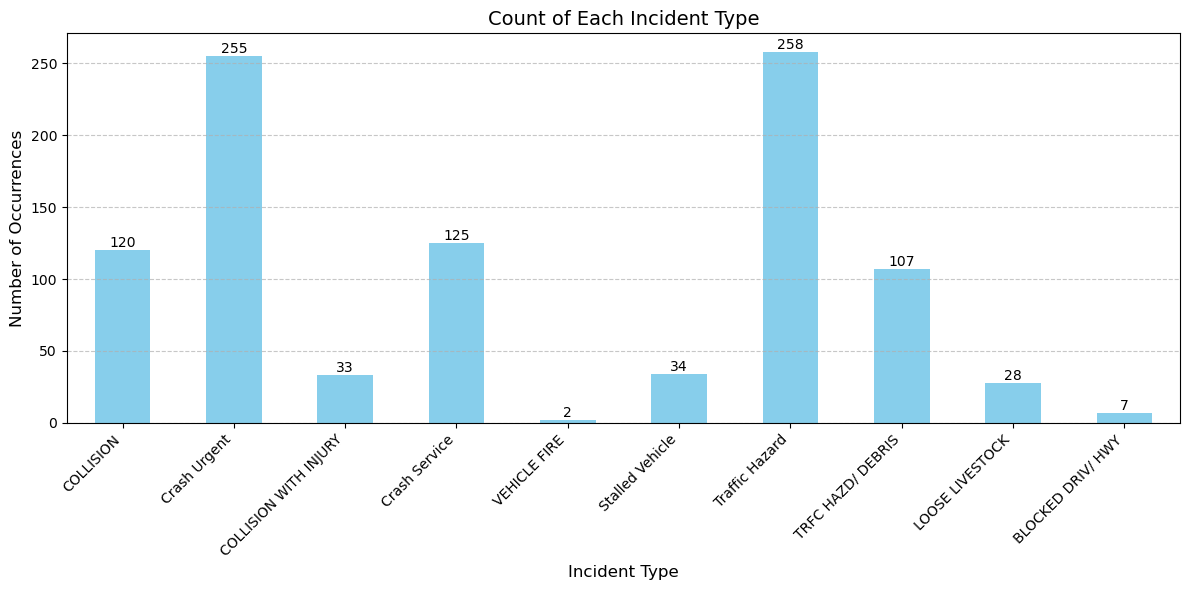

In [22]:

# Set order for bars
custom_order = [
    'COLLISION',
    'Crash Urgent',
    'COLLISION WITH INJURY',
    'Crash Service',
    'VEHICLE FIRE',
    'Stalled Vehicle',
    'Traffic Hazard',
    'TRFC HAZD/ DEBRIS',
    'LOOSE LIVESTOCK',
    'BLOCKED DRIV/ HWY'
]

# Get value counts &
# Filter and reorder (keeps only items in `custom_order` {above})
incident_counts = traffic_df['issue_reported'].value_counts().reindex(custom_order)

# Drop NaN (if some categories don't exist in data)
incident_counts = incident_counts.dropna()

# Create the plot
plt.figure(figsize=(12, 6))
bars = incident_counts.plot(kind='bar', color='skyblue')

# Customize the plot
plt.title('Count of Each Incident Type', fontsize=14)
plt.xlabel('Incident Type', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

# Add data labels on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, 
            bar.get_height(), 
            int(bar.get_height()), 
            ha='center', 
            va='bottom')

plt.tight_layout()  # Adjust layout to prevent label cutoff

# # Save the figure before showing it
# plt.savefig('austin_incidents_by_type.png',  # File name
#             dpi=300,                      # High resolution
#             bbox_inches='tight',           # Prevent cropping
#             facecolor='white')            # White background

plt.show()

#### How many across time?

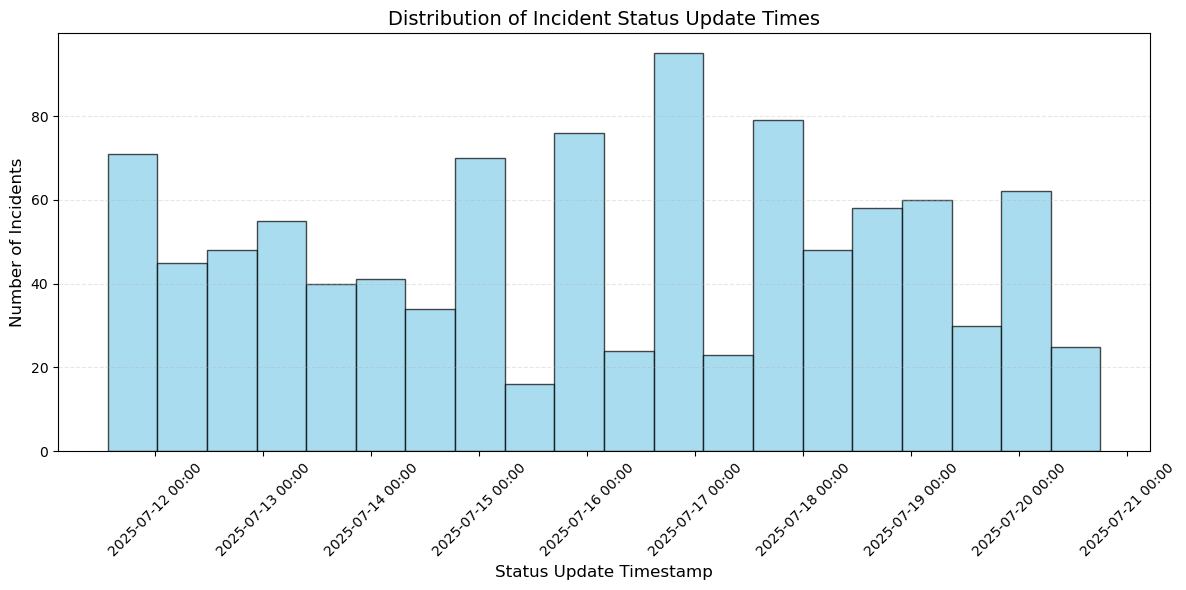

In [24]:
# Ensure datetime format (if not already converted)
traffic_df['traffic_report_status_date_time'] = pd.to_datetime(traffic_df['traffic_report_status_date_time'])

# Create histogram
plt.figure(figsize=(12, 6))

# Plot with custom bins and edge color
n_bins = 20  # Adjust for granularity
plt.hist(traffic_df['traffic_report_status_date_time'], 
         bins=n_bins, 
         color='skyblue', 
         edgecolor='black',
         alpha=0.7)

# Format x-axis as dates
date_format = DateFormatter('%Y-%m-%d %H:%M')  # Include hours/minutes if needed
plt.gca().xaxis.set_major_formatter(date_format)

# Customize
plt.title('Distribution of Incident Status Update Times', fontsize=14)
plt.xlabel('Status Update Timestamp', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()

# # Save the figure before showing it
# plt.savefig('austin_incidents_by_update_times.png',  # File name
#             dpi=300,                      # High resolution
#             bbox_inches='tight',           # Prevent cropping
#             facecolor='white')            # White background

plt.show()

Incident counts by days of the week

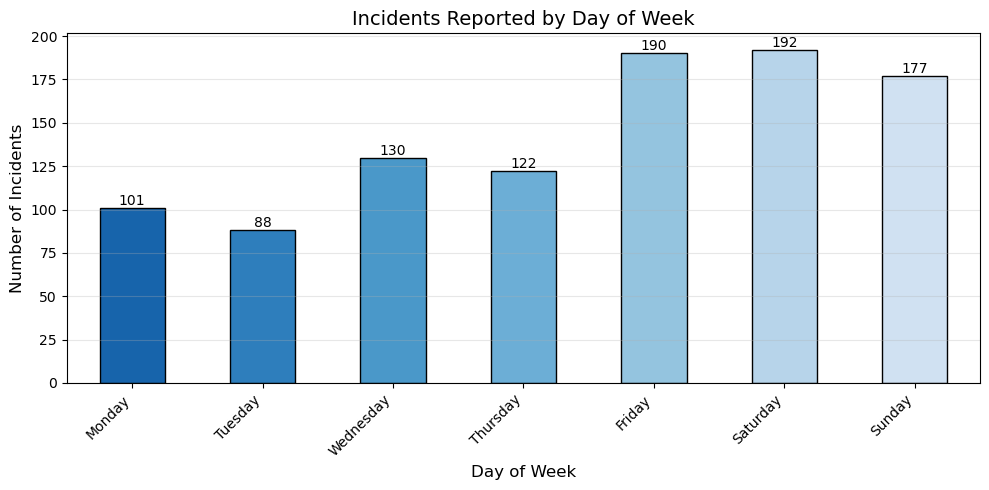

In [15]:
# Convert to datetime (if not already)
traffic_df['traffic_report_status_date_time'] = pd.to_datetime(traffic_df['traffic_report_status_date_time'])

# Extract day names (e.g., "Monday", "Tuesday")
traffic_df['day_of_week'] = traffic_df['traffic_report_status_date_time'].dt.day_name()

# Define correct weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert to categorical with correct ordering
traffic_df['day_of_week'] = pd.Categorical(
    traffic_df['day_of_week'], 
    categories=weekday_order, 
    ordered=True
)

day_counts = traffic_df['day_of_week'].value_counts().sort_index()

plt.figure(figsize=(10, 5))

# Plot bars with color gradient
colors = plt.cm.Blues_r(np.linspace(0.2, 0.8, 7))  # 7 days, blue gradient
day_counts.plot(kind='bar', color=colors, edgecolor='black')

# Customize
plt.title('Incidents Reported by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, count in enumerate(day_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()

# # Save the figure before showing it
# plt.savefig('austin_incidents_by_weekday.png',  # File name
#             dpi=300,                      # High resolution
#             bbox_inches='tight',           # Prevent cropping
#             facecolor='white')            # White background

plt.show()

What about time of day?\
Does whether the sun is up affect traffic incidents?\
[Sunset/Sunrise API](https://sunrise-sunset.org/api)

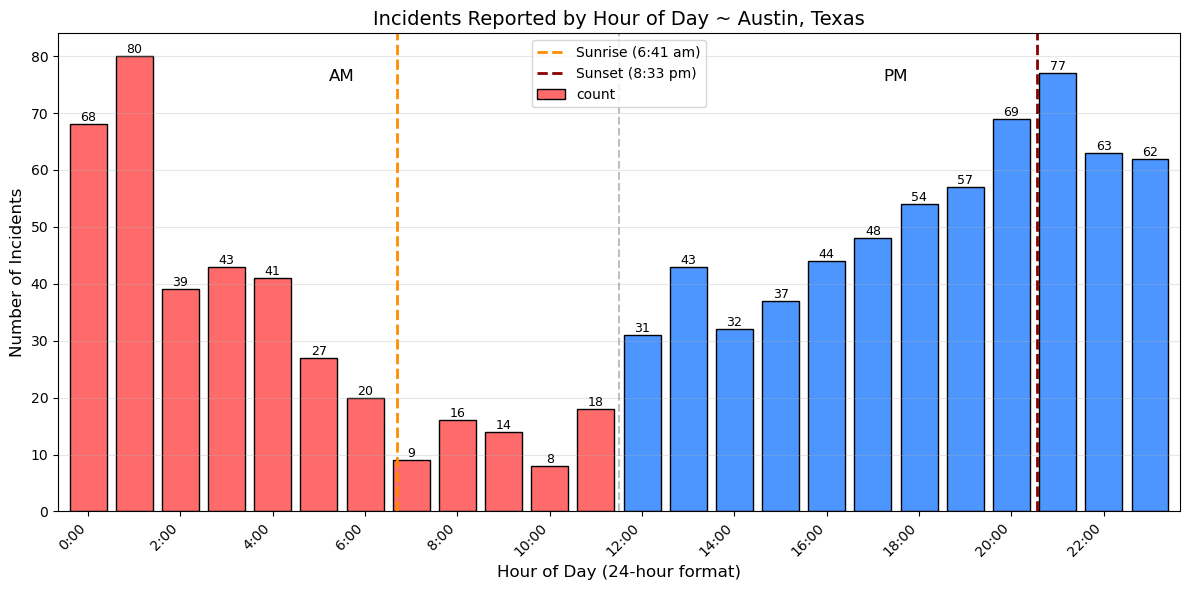

In [14]:
# --- 1. Get Austin sunrise/sunset times ---
def get_austin_sun_times():
    params = {
        'lat': 30.2672,
        'lng': -97.7431,
        'formatted': 0,
        'tzid': 'America/Chicago'
    }
    response = requests.get('https://api.sunrise-sunset.org/json', params=params)
    data = response.json()['results']
    
    sunrise = pd.to_datetime(data['sunrise'])
    sunset = pd.to_datetime(data['sunset'])
    
    # Return both decimal hours AND formatted strings
    return (
        sunrise.hour + sunrise.minute/60,  # Keep for positioning
        sunset.hour + sunset.minute/60,    # Keep for positioning
        sunrise.strftime('%-I:%M %p').lower(),  # New: e.g. "6:42 am"
        sunset.strftime('%-I:%M %p').lower()    # New: e.g. "6:15 pm"
    )

# assign sunrise/sunset vars
sunrise_pos, sunset_pos, sunrise_str, sunset_str = get_austin_sun_times()

# --- 2. plotting
traffic_df['hour_of_day'] = traffic_df['traffic_report_status_date_time'].dt.hour
hour_counts = traffic_df['hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
colors = ['#ff6b6b' if hour < 12 else '#4d96ff' for hour in hour_counts.index]
hour_counts.plot(kind='bar', color=colors, edgecolor='black', width=0.8)

plt.title('Incidents Reported by Hour of Day ~ Austin, Texas', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(np.arange(0, 24, 2), 
           [f"{h}:00" for h in np.arange(0, 24, 2)],
           rotation=45, 
           ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels
for hour, count in hour_counts.items():
    plt.text(hour, count, str(count), 
             ha='center', va='bottom',
             fontsize=9)

# --- 3. Add sunrise/sunset lines ---
plt.axvline(x=sunrise_pos, color='#FF8C00', linestyle='--', linewidth=2, label=f'Sunrise ({sunrise_str})')
plt.axvline(x=sunset_pos, color='#8B0000', linestyle='--', linewidth=2, label=f'Sunset ({sunset_str})')

# Keep your AM/PM divider
plt.axvline(x=11.5, color='gray', linestyle='--', alpha=0.5)
plt.text(5.5, plt.ylim()[1]*0.9, 'AM', ha='center', fontsize=12)
plt.text(17.5, plt.ylim()[1]*0.9, 'PM', ha='center', fontsize=12)

# Add legend
plt.legend()

plt.tight_layout()

# # Save the figure before showing it
# plt.savefig('austin_incidents_by_hour.png',  # File name
#             dpi=300,                      # High resolution
#             bbox_inches='tight',           # Prevent cropping
#             facecolor='white')            # White background

plt.show()

#### Which areas?

In [21]:
# Load and clean your data
df_clean = traffic_df.dropna(subset=['latitude', 'longitude'])
df_clean['latitude'] = pd.to_numeric(df_clean['latitude'])
df_clean['longitude'] = pd.to_numeric(df_clean['longitude'])

# Create base map centered on Austin
m = folium.Map(
    location=[30.2672, -97.7431],
    zoom_start=12,
    tiles='OpenStreetMap',
    attr='OpenStreetMap contributors'
)

# Create heatmap data
heat_data = [[row['latitude'], row['longitude']] for idx, row in df_clean.iterrows()]

# Add heatmap layer (always visible)
HeatMap(heat_data,
        radius=15,
        blur=20,
        max_zoom=13,
        gradient={0.4: 'blue', 0.6: 'lime', 0.8: 'orange', 1.0: 'red'}
       ).add_to(m)

# Create a FeatureGroup for markers (hidden by default)
marker_group = folium.FeatureGroup(name='Incident Icons', show=False)
m.add_child(marker_group)

# Add individual markers to the hidden group
for idx, row in df_clean.iterrows():
    popup_text = f"""
    <b>Type:</b> {row['issue_reported']}<br>
    <b>Date:</b> {row['traffic_report_status_date_time']}<br>
    <b>Status:</b> {row.get('traffic_report_status', 'N/A')}
    """
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=250),
        icon=folium.Icon(color='red', icon='car', prefix='fa')
    ).add_to(marker_group)

# Add light mode alternative
folium.TileLayer(
    tiles='CartoDB positron',
    attr='© OpenStreetMap contributors © CARTO',
    name='Light Mode'
).add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Add title directly on the map canvas
title_html = '''
    <div style="position: absolute; 
                top: 20px; 
                left: 20px; 
                z-index: 1000;
                background-color: rgba(255, 255, 255, 0.8);
                padding: 10px 15px;
                border-radius: 5px;
                border: 1px solid #ccc;
                font-family: Arial, sans-serif;
                box-shadow: 0 1px 3px rgba(0,0,0,0.2);
                max-width: 300px;">
        <h3 style="margin: 0 0 5px 0; font-size: 16px; color: #333;">
            🚗 Austin Traffic Incidents
        </h3>
        <p style="margin: 0; font-size: 12px; color: #555;">
            <b>Hotspots</b> shown in red<br>
            {n_incidents:,} total incidents<br>
            {date_range}
        </p>
    </div>
'''.format(
    n_incidents=len(df_clean),
    date_range=f"{df_clean['traffic_report_status_date_time'].min().strftime('%b %d %Y')} to {df_clean['traffic_report_status_date_time'].max().strftime('%b %d %Y')}"
)

# Add to map
m.get_root().html.add_child(folium.Element(title_html))

# # Save and display
# m.save('austin_incidents_heatmap.html')

display(m)